# Financial Econometrics - Homework 1

**Professor**: Jeroen V.K. Rombouts

**Date**: April , 2024

---

## Group Members

- Zheng WAN
- Yash SHAH
- Larry SANG

# Import Libraries and Data

In [ ]:
import yfinance as yf
import datetime
from scipy.stats import skew, kurtosis, norm, ks_2samp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
import math
import matplotlib.dates as mdates
from scipy import stats
import requests
from bs4 import BeautifulSoup
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
def fetch_sp500_data(start_date, end_date):
    # Function to fetch the S&P 500 ticker symbols
    def get_sp500_tickers():
        table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        sp500 = table[0]
        tickers = sp500['Symbol'].tolist()
        tickers = [ticker.replace('.', '-') for ticker in tickers]  # Yahoo Finance uses hyphens instead of dots
        return tickers

    # Function to download historical data
    def download_data(tickers, start_date, end_date):
        # This downloads the data for all tickers and returns a single DataFrame with adjusted closing prices
        return yf.download(tickers, start=start_date, end=end_date)['Adj Close']

    # Get S&P 500 tickers
    tickers = get_sp500_tickers()

    # Add the S&P 500 index itself
    tickers.append('^GSPC')

    # Download data
    sp500_data = download_data(tickers, start_date, end_date)

    return sp500_data

In [ ]:
# Define the date range
start_date = '2010-01-01'
end_date = datetime.date.today()

# Fetch the data for the given date range
sp500_data = fetch_sp500_data(start_date, end_date)

# Display the first few rows of the data
sp500_data.head()

[*********************100%%**********************]  504 of 504 completed


Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122229,4.496876,6.470741,NaN,NaN,18.952164,7.994444,32.212460,37.090000,22.530371,...,9.905469,41.538418,12.918805,40.237785,NaN,19.158091,52.587044,28.670000,NaN,1132.989990
2010-01-05,19.903650,5.005957,6.481928,NaN,NaN,18.799044,7.967778,32.411545,37.700001,22.494810,...,10.115746,44.064747,12.765593,40.394890,NaN,19.092575,54.251751,28.620001,NaN,1136.520020
2010-01-06,19.832930,4.798554,6.378824,NaN,NaN,18.903442,7.933333,32.756096,37.619999,22.452118,...,10.003898,43.486744,12.790111,40.744030,NaN,18.956091,54.234230,28.400000,NaN,1137.140015
2010-01-07,19.807213,4.939966,6.367033,NaN,NaN,19.060040,7.886667,32.725464,36.889999,22.274271,...,9.959158,44.415440,12.734955,40.616024,NaN,18.950619,55.478371,27.690001,NaN,1141.689941
2010-01-08,19.800785,4.845692,6.409362,NaN,NaN,19.157484,7.871111,32.595303,36.689999,22.402321,...,9.867436,44.097218,12.741086,40.453091,NaN,18.956091,54.313080,27.600000,NaN,1144.979980


In [ ]:
# Check Null
missing_data_summary = sp500_data.isnull().sum()
missing_data_tickers = missing_data_summary[missing_data_summary > 0]
print(missing_data_tickers)

Ticker
ABBV     754
ABNB    2754
ALLE     976
AMCR     596
ANET    1113
        ... 
VICI    2013
VLTO    3461
WRK     1377
XYL      449
ZTS      775
Length: 67, dtype: int64


In [ ]:
# I tried to deal with null here but did not work,instead fillna latter after log transformation with 0
sp500_data_interpolated = sp500_data.interpolate(method='linear', axis=0)
print(sp500_data_interpolated.isnull().sum())

Ticker
A           0
AAL         0
AAPL        0
ABBV      754
ABNB     2754
         ... 
YUM         0
ZBH         0
ZBRA        0
ZTS       775
^GSPC       0
Length: 504, dtype: int64


Log transfer

In [ ]:
def calculate_log_returns(data):
    """
    Calculate log returns from percentage changes.

    Parameters:
    - data: DataFrame, containing the data for which log returns need to be calculated.

    Returns:
    - log_returns: DataFrame, containing the calculated log returns.
    """
    # Calculate the percentage changes
    percentage_changes = data.pct_change()

    # Calculate the log returns
    log_returns = np.log(1 + percentage_changes) * 100

    return log_returns

In [ ]:
log_returns = calculate_log_returns(sp500_data)
log_returns.tail()

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-18,-1.580617,0.931573,-0.573071,0.249311,1.086462,-0.596682,0.835080,0.463093,-0.268041,-0.981409,...,-0.540800,-1.425796,1.065928,-0.092769,0.741974,0.029012,-1.637406,-1.132636,1.051812,-0.221060
2024-04-19,0.218723,0.639883,-1.228779,1.057188,-3.230906,1.891378,1.671047,0.278096,-1.739546,-2.275399,...,0.382041,-1.161770,1.769963,1.140953,0.533329,0.455915,0.083765,-1.833351,-4.413119,-0.879713
2024-04-22,0.885100,2.933172,0.507797,0.885435,1.026905,-0.195940,0.985122,0.170269,0.401332,1.596050,...,0.000000,2.587566,0.437634,0.565631,0.887787,0.403515,1.124027,1.319270,-0.657451,0.869335
2024-04-23,3.874377,-2.086308,0.637135,0.977985,2.733510,0.484485,-0.074615,-0.186055,1.279022,1.924360,...,0.759737,1.365275,0.562464,0.389090,1.340032,0.745102,0.610813,1.798692,2.724672,1.189357
2024-04-24,-1.236050,-2.202572,1.262228,-1.031604,1.167436,-0.652741,-0.631115,-1.043834,0.888408,3.400689,...,-0.537545,-1.797069,0.108502,0.016527,-0.038259,1.213162,-0.288433,0.350124,0.878722,0.021299


In [ ]:
log_returns.isnull().sum()

Ticker
A           1
AAL         1
AAPL        1
ABBV      755
ABNB     2755
         ... 
YUM         1
ZBH         1
ZBRA        1
ZTS       776
^GSPC       1
Length: 504, dtype: int64

## Question 1





In [ ]:
def calculate_moments(data):
    stats = pd.DataFrame(columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'])
    for ticker in data:
        row = data[ticker].dropna()
        T = len(row)
        # print(T)
        if T == 0:
            print("Am I even useful?")
            stats.loc[ticker] = [np.nan, np.nan, np.nan, np.nan]
        else:
            mu=(1/T)*np.sum(row)
            sig2 = 1/(T-1) * np.sum([np.square((x - mu)) for x in row])
            sk = 1/((T-1) * math.pow(math.sqrt(sig2),3)) * np.sum([math.pow(x - mu,3) for x in row])
            ku = 1/((T-1) * math.pow(math.sqrt(sig2),4)) * np.sum([math.pow(x - mu,4) for x in row])-3
            stats.loc[ticker] = [mu, math.sqrt(sig2), sk, ku]

    return stats

In [ ]:
statistics_matrix = calculate_moments(log_returns)

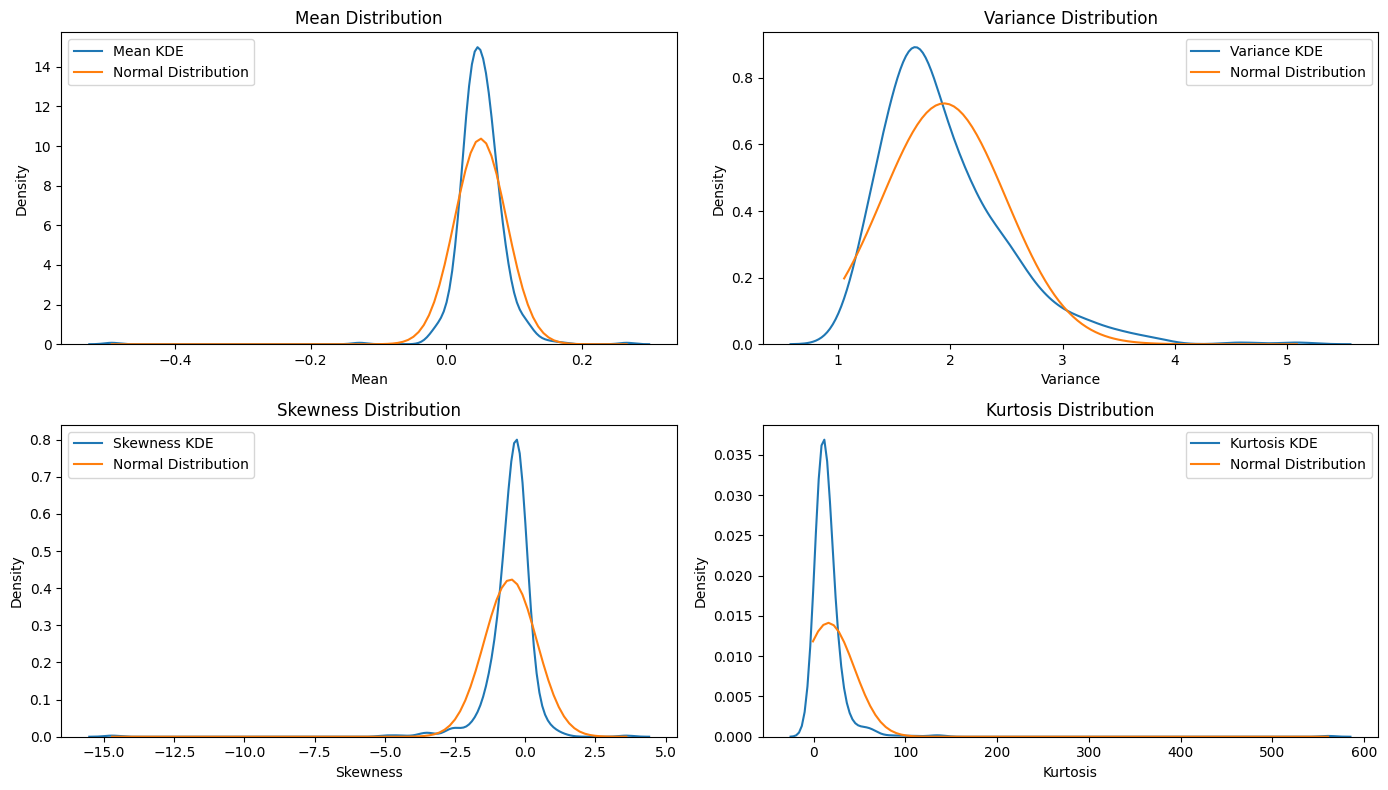

In [ ]:
statistics_list = ['Mean', 'Variance', 'Skewness', 'Kurtosis']

# Initialize a matplotlib subplot with 4 plots (2x2)
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax = ax.ravel()

for i, stat in enumerate(statistics_list):
    # Extract the values
    values = statistics_matrix[stat]

    # Calculate the density estimate
    sns.kdeplot(values, ax=ax[i], label=f'{stat} KDE')

    # Calculate mean and variance for the normal distribution
    mean_val = values.mean()
    std_val = values.std()

    # Generate points for a range of values
    x = np.linspace(values.min(), values.max(), 100)

    # Plot the normal distribution with calculated mean and standard deviation
    ax[i].plot(x, norm.pdf(x, mean_val, std_val), label='Normal Distribution')

    # Set plot titles and legends
    ax[i].set_title(f'{stat} Distribution')
    ax[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Comments:

For the mean, most log return/percentage return were centralized around 0.05%, which signals a generally positive performance in most stocks every day. But there are some fat tails worth note. Some fat tails contain values slightly negative,around -0.0125%, while some are extremely better, over 0.125%, which are really amazing.

For the variance, it has a more obvious "thin head" and more obvious "fat tails". Most of values are smaller than 5, which indicates low volatility every day, while there are a bunch of stocks which has a variance over 10, which indicates existence of some extreme volatile cases.

For the skewness, most values are centralized around 0, but it seems that there are more negative values, which indicates more frequent smaller returns in most stocks.

The (excess) kurtosis of the distribution of returns for most stocks is positive, making it more peaked than a normal distribution and showing more extreme value, which means that most stocks have a thin-head and fat-tails distributions in terms of the log-returns.

## Question 2

**Questions Regarding how to fill nan**

In [ ]:
import matplotlib.dates as mdates

# Convert datetime index to matplotlib float format
x = mdates.date2num(log_returns.index.to_pydatetime())

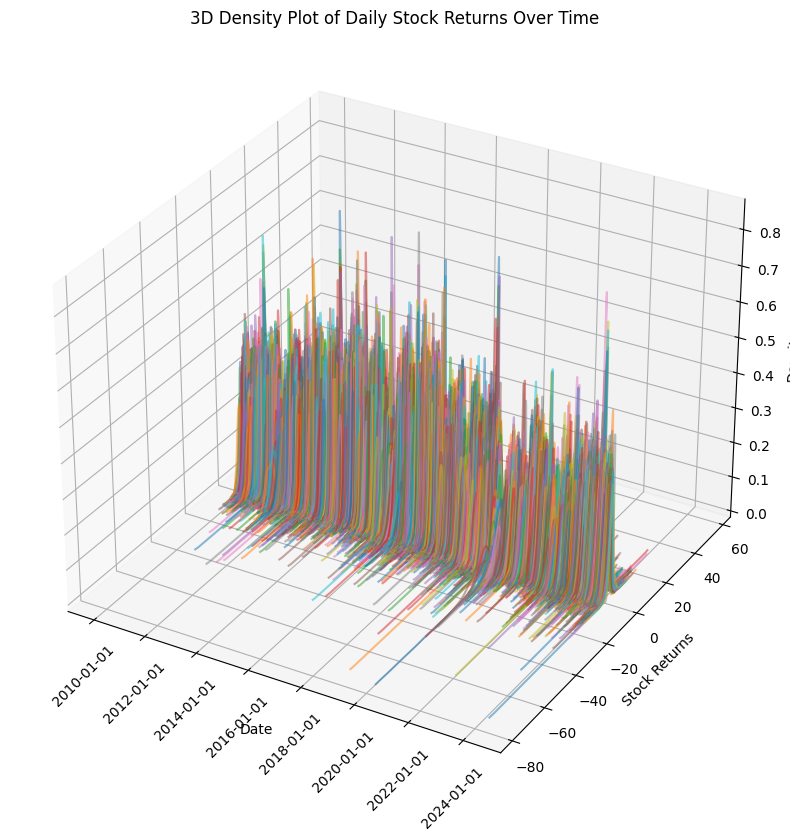

In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure for the 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Iterate over each day, calculate KDE, and plot
for i, (date, daily_returns) in enumerate(log_returns.iterrows()):
    data = daily_returns.dropna()
    if len(data) > 1:  # Ensure there's enough data to compute KDE
        try:
            kde = gaussian_kde(data)
            # Evaluate KDE on a range of data points
            kde_space = np.linspace(min(data), max(data), 100)
            density = kde(kde_space)
            ax.plot(np.full_like(kde_space, mdates.date2num(date.to_pydatetime())), kde_space, density, alpha=0.5)
        except np.linalg.LinAlgError:
            print(f"Failed to compute KDE for {date} due to singular matrix issues.")
            continue  # Skip this iteration if KDE computation fails

# Formatting the x-axis to show dates properly
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Labeling the axes
ax.set_xlabel('Date')
ax.set_ylabel('Stock Returns')
ax.set_zlabel('Density')

# Rotate the x-axis labels for better visibility
for label in ax.get_xticklabels():
    label.set_rotation(45)


plt.title('3D Density Plot of Daily Stock Returns Over Time')
plt.show()

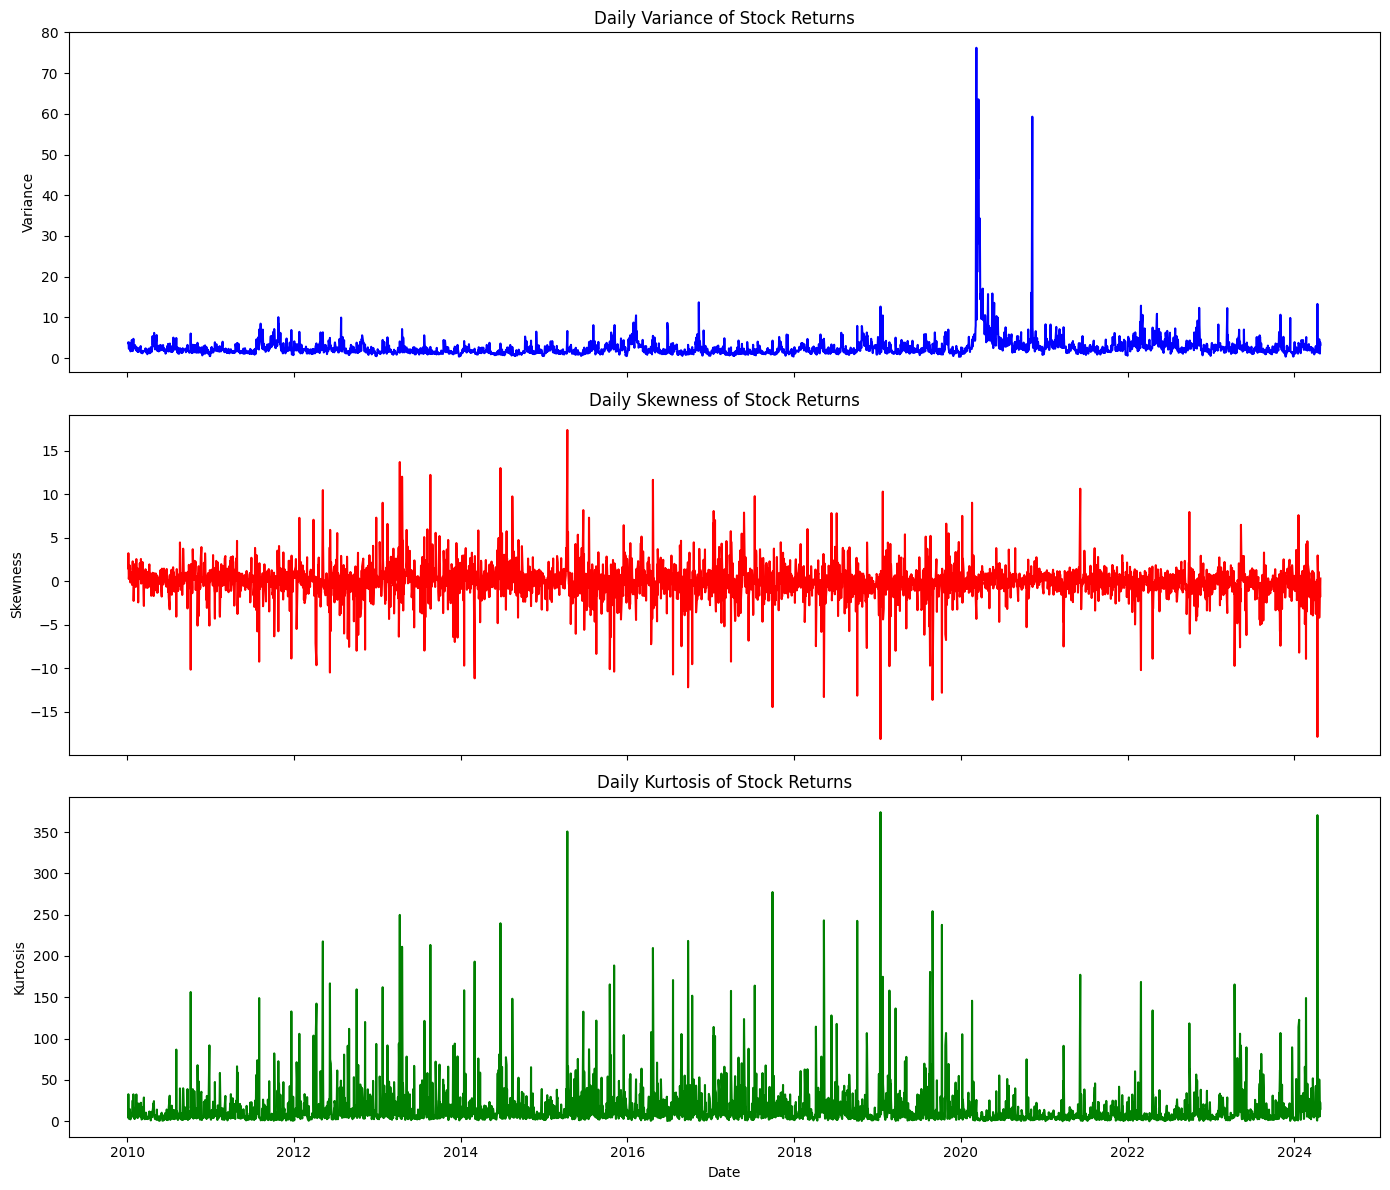

In [ ]:
# Calculate daily statistics
daily_variance = log_returns.var(axis=1)
daily_skewness = log_returns.skew(axis=1)
daily_kurtosis = log_returns.kurtosis(axis=1)

# Plotting time series of each statistic
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(log_returns.index, daily_variance, label='Daily Variance', color='blue')
axes[0].set_title('Daily Variance of Stock Returns')
axes[0].set_ylabel('Variance')

axes[1].plot(log_returns.index, daily_skewness, label='Daily Skewness', color='red')
axes[1].set_title('Daily Skewness of Stock Returns')
axes[1].set_ylabel('Skewness')

axes[2].plot(log_returns.index, daily_kurtosis, label='Daily Kurtosis', color='green')
axes[2].set_title('Daily Kurtosis of Stock Returns')
axes[2].set_ylabel('Kurtosis')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_statistics(returns):
    T = len(returns)
    if T == 0:
        return np.nan, np.nan, np.nan, np.nan  # Handle empty data

    mu = (1/T) * np.sum(returns)
    sig2 = np.var(returns, ddof=1)
    sk = (1 / ((T - 1) * np.power(np.sqrt(sig2), 3))) * np.sum(np.power(returns - mu, 3))
    ku = (1 / ((T - 1) * np.power(np.sqrt(sig2), 4))) * np.sum(np.power(returns - mu, 4)) - 3

    return mu, sig2, sk, ku

# Assuming log_returns is a DataFrame with each column as a stock's return series
statistics = {stock: calculate_statistics(log_returns[stock]) for stock in log_returns.columns}
stats_df = pd.DataFrame(statistics).T
stats_df.columns = ['Mean', 'Variance', 'Skewness', 'Kurtosis']

In [ ]:
# Calculate daily statistics
daily_stats = log_returns.apply(lambda x: calculate_statistics(x.dropna()), axis=1)

# Convert the list of tuples into a DataFrame
daily_stats_df = pd.DataFrame(list(daily_stats), index=log_returns.index, columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'])


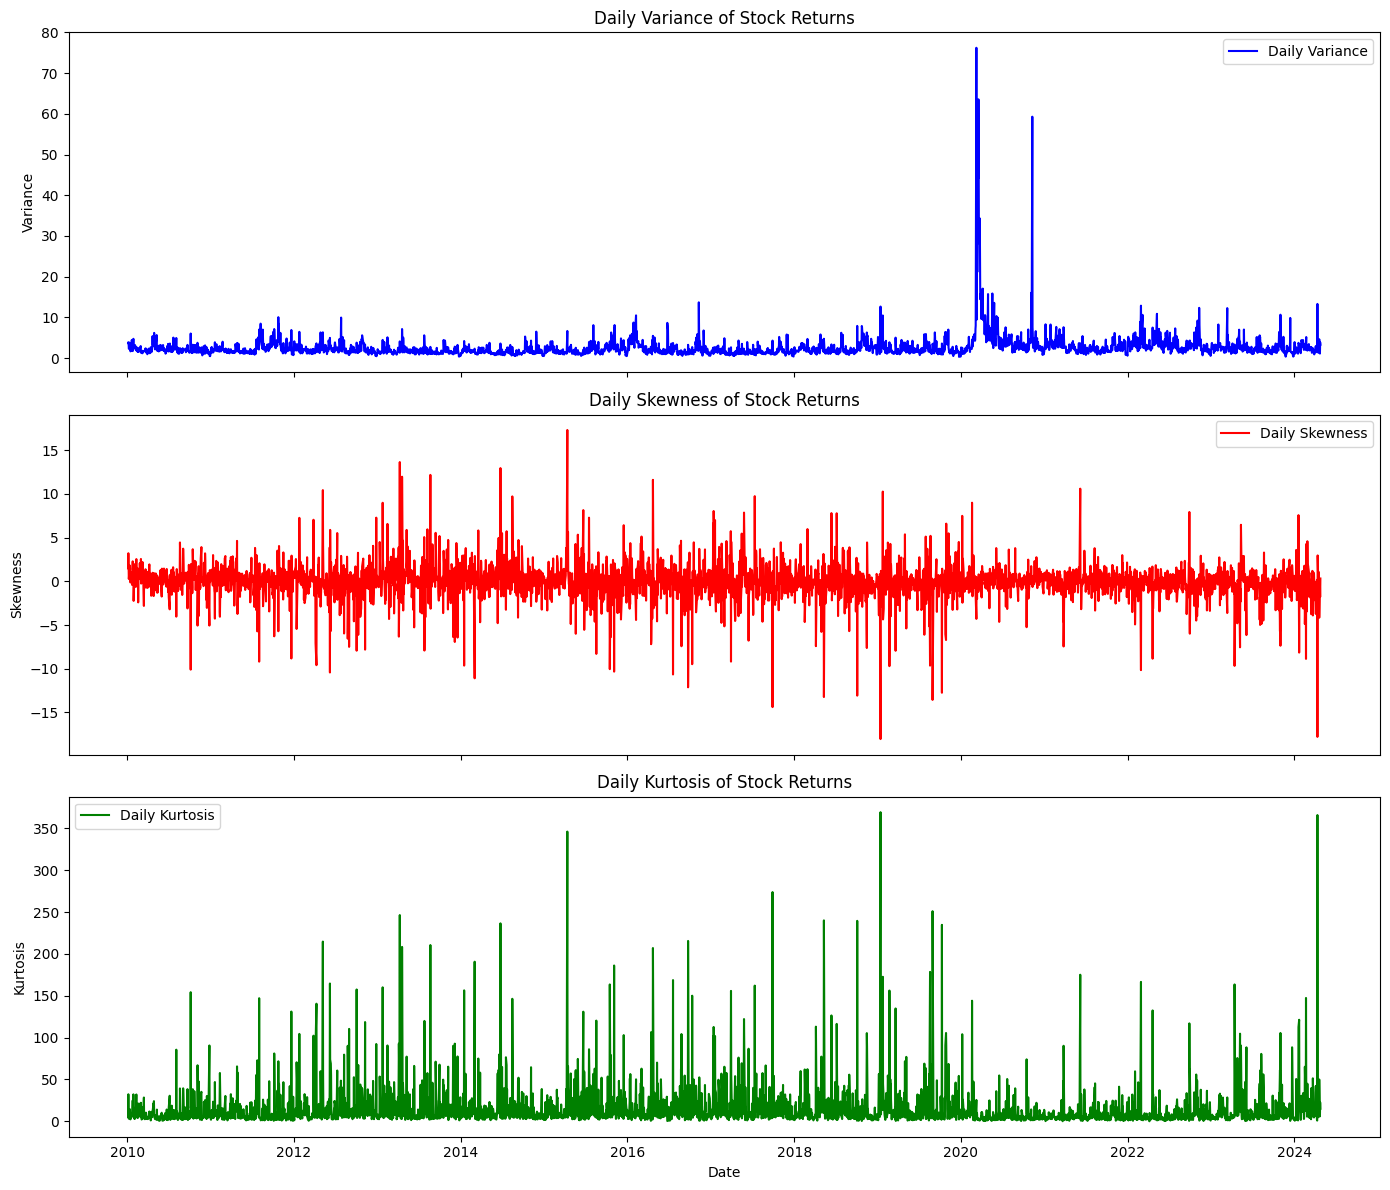

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(daily_stats_df.index, daily_stats_df['Variance'], label='Daily Variance', color='blue')
axes[0].set_title('Daily Variance of Stock Returns')
axes[0].set_ylabel('Variance')

axes[1].plot(daily_stats_df.index, daily_stats_df['Skewness'], label='Daily Skewness', color='red')
axes[1].set_title('Daily Skewness of Stock Returns')
axes[1].set_ylabel('Skewness')

axes[2].plot(daily_stats_df.index, daily_stats_df['Kurtosis'], label='Daily Kurtosis', color='green')
axes[2].set_title('Daily Kurtosis of Stock Returns')
axes[2].set_ylabel('Kurtosis')
axes[2].set_xlabel('Date')

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


It is hard to tell the trend in 3D plot about the performances in each day. But we can still see that there are days whose most values are negative and there exist more negative extreme values than positive extreme values.

When checking out the variance, there are many days which have large variances from time to time. And it appears that the variances around COVID-19 epidemic are extremely larger, which means that there were huge amounts of stocks which had very different return performances, signifying that different sectors may change in different directions due to the impact of the epidemic.

The vast majority of days seemed to have a skewed distribution due to their non-zero skewness, but most skewness was close to 0. And negative skewness seems to appear slightly more often than positive ones.

Most days have very high kurtosis, which indicates that there exist many extreme returns on vast majority of days.

## Question 3

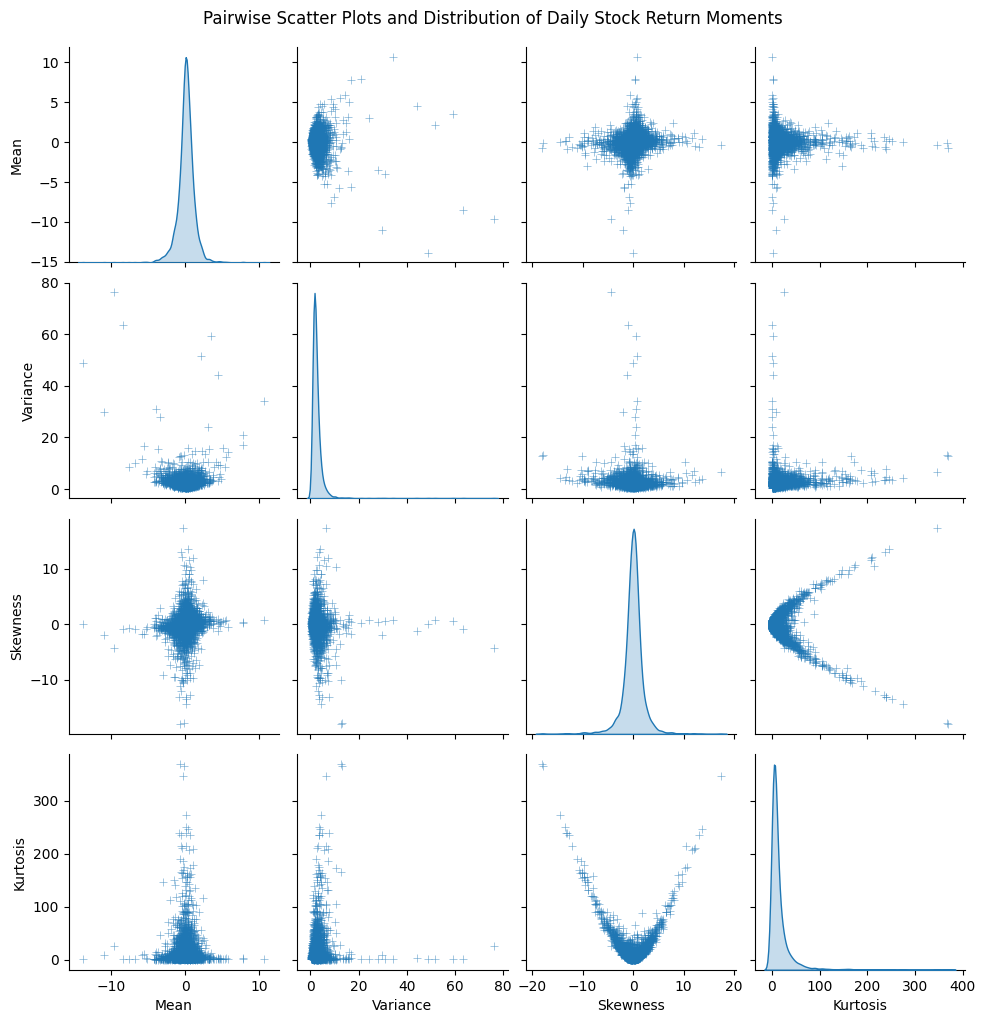

In [ ]:
# Create a pairplot of the daily statistics
sns.pairplot(daily_stats_df, diag_kind='kde', markers='+', plot_kws={'alpha': 0.6})
plt.suptitle('Pairwise Scatter Plots and Distribution of Daily Stock Return Moments', y=1.02)
plt.show()

####Mean vs. Variance
There's a discernible trend where points spread outwards in a funnel shape as we move right or left, this indicates heteroskedasticity — variance increasing with the absolute mean. This suggests that days with higher average returns may also exhibit greater variability or risk, which is a common pattern in financial returns due to volatile markets or specific events impacting stock prices.

####Mean vs. Skewness
The points are spread around the center, which could indicate that the relationship between average returns and asymmetry of returns is weak or complex. A lack of strong pattern here suggests that the mean return does not reliably predict the direction or magnitude of skewness on a given day.But most distributions have high absolute skewness and high absolute mean at the same time.

####Mean vs. Kurtosis
The distributions which have means close to 0 have larger likelihood to have fatter/heavier tails, though most distribtuions have mean close to 0 and large kurtosis. And the distributions which have more extreme means have smaller likelihood to have fatter/heavier tails. It means that on most very bad/good days, most stocks changed in roughly the same direction.

####Variance vs. Skewness
The scatter implies that the variance of 500 returns doesn't necessarily predict how asymmetric the return distribution is.

####Variance vs. Kurtosis
Most Kurtosis are very large on most days, so it is hard to find out the relationship between this two. In a range, there might be a positive relationship. But it is rare to see really extreme variance and really extreme kurtosis.

####Skewness vs. Kurtosis
Like the relationship between variance and mean, higher moments are not independent.Larger absolute values of skewness always coexists with larger kurtosis. It indicates that the days with asymmetric return distributions (skewed to the right or left) also tend to have heavier or lighter tails than a normal distribution. This could have implications for the probability of extreme returns.

## Question 4

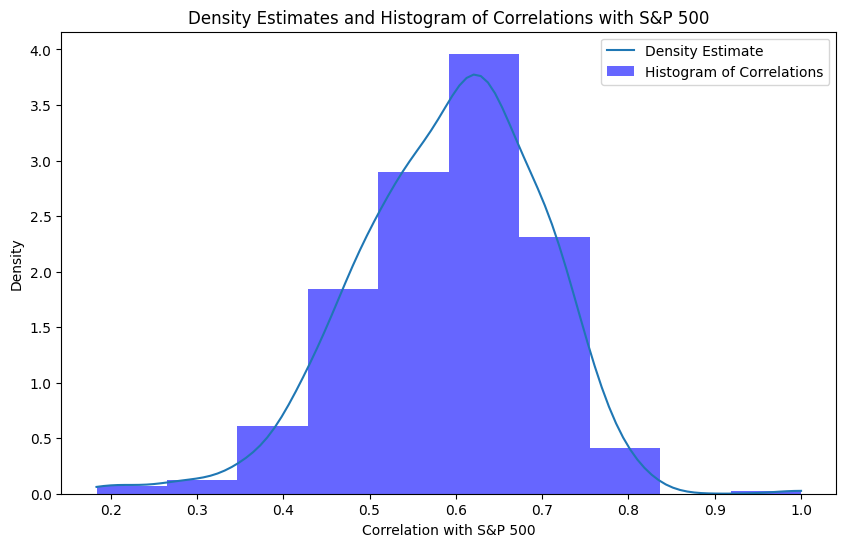

In [ ]:
sp500_column = "^GSPC"  # S&P 500 column name

correlations = log_returns.corrwith(log_returns[sp500_column])  # Correlation with S&P 500

# Compute nonparametric density estimates (KDE) for the correlations
correlations_values = correlations.values
kde = gaussian_kde(correlations_values)  # Kernel Density Estimation
x_range = np.linspace(min(correlations_values), max(correlations_values), 100)
density = kde(x_range)  # Calculate density

# Plot the nonparametric density estimates
plt.figure(figsize=(10, 6))
plt.plot(x_range, density, label='Density Estimate')
plt.hist(correlations_values, density=True, alpha=0.6, color='b', label='Histogram of Correlations')  # Histogram with density normalization
plt.xlabel("Correlation with S&P 500")
plt.ylabel("Density")
plt.title("Density Estimates and Histogram of Correlations with S&P 500")
plt.legend()
plt.show()  # Display the plot

The density plot showing most correlations between 0.4 and 0.8 would typically be interpreted as indicating that individual stocks have a moderate to strong positive relationship with the S&P 500, reflecting both market influence and individual stock characteristics. It makes sense since S&P500 is composed by these stocks. This knowledge can help investors manage risk and seek diversification in their portfolios.

## Question 5

In [ ]:
# Separate data into two periods
log_returns_pre_2020 = log_returns[log_returns.index < '2020-01-01']
log_returns_2020_onwards = log_returns[log_returns.index >= '2020-01-01']

# Calculate statistics for each period
stats_pre_2020 = {stock: calculate_statistics(log_returns_pre_2020[stock]) for stock in log_returns_pre_2020.columns}
stats_2020_onwards = {stock: calculate_statistics(log_returns_2020_onwards[stock]) for stock in log_returns_2020_onwards.columns}

stats_df_pre_2020 = pd.DataFrame(stats_pre_2020).T
stats_df_pre_2020.columns = ['Mean', 'Variance', 'Skewness', 'Kurtosis']

stats_df_2020_onwards = pd.DataFrame(stats_2020_onwards).T
stats_df_2020_onwards.columns = ['Mean', 'Variance', 'Skewness', 'Kurtosis']

In [ ]:
def plot_density_with_normal_overlay(data, title):
    density = gaussian_kde(data.dropna())
    x = np.linspace(min(data), max(data), 1000)
    plt.plot(x, density(x), label='KDE')
    plt.plot(x, norm.pdf(x, np.mean(data), np.sqrt(np.var(data))), label='Normal', linestyle='--')
    plt.title(title)
    plt.legend()




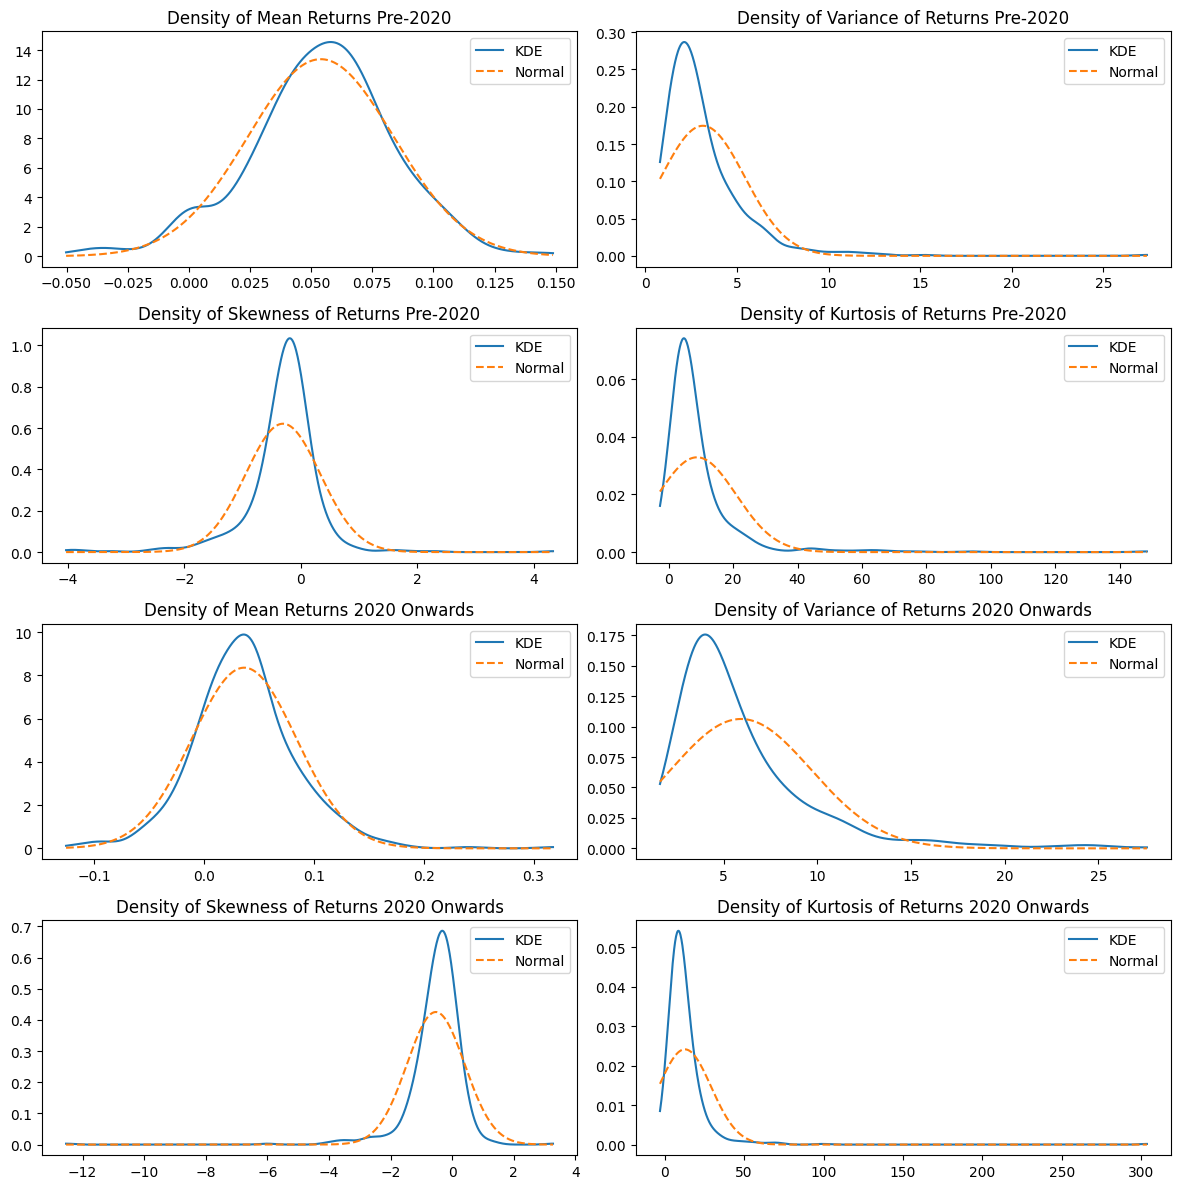

In [ ]:

plt.figure(figsize=(12, 12))

# before 2020
plt.subplot(4, 2, 1)
plot_density_with_normal_overlay(stats_df_pre_2020['Mean'], 'Density of Mean Returns Pre-2020')

plt.subplot(4, 2, 2)
plot_density_with_normal_overlay(stats_df_pre_2020['Variance'], 'Density of Variance of Returns Pre-2020')

plt.subplot(4, 2, 3)
plot_density_with_normal_overlay(stats_df_pre_2020['Skewness'], 'Density of Skewness of Returns Pre-2020')

plt.subplot(4, 2, 4)
plot_density_with_normal_overlay(stats_df_pre_2020['Kurtosis'], 'Density of Kurtosis of Returns Pre-2020')

# after
plt.subplot(4, 2, 5)
plot_density_with_normal_overlay(stats_df_2020_onwards['Mean'], 'Density of Mean Returns 2020 Onwards')

plt.subplot(4, 2, 6)
plot_density_with_normal_overlay(stats_df_2020_onwards['Variance'], 'Density of Variance of Returns 2020 Onwards')

plt.subplot(4, 2, 7)
plot_density_with_normal_overlay(stats_df_2020_onwards['Skewness'], 'Density of Skewness of Returns 2020 Onwards')

plt.subplot(4, 2, 8)
plot_density_with_normal_overlay(stats_df_2020_onwards['Kurtosis'], 'Density of Kurtosis of Returns 2020 Onwards')


plt.tight_layout()

plt.show()


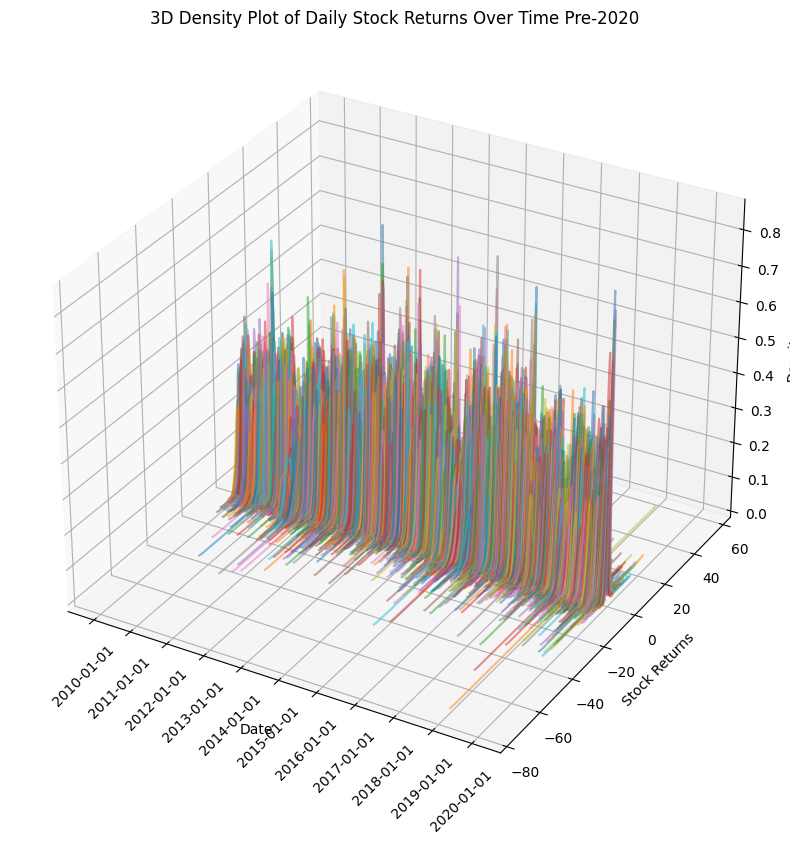

In [ ]:
# Create a new figure for the 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Iterate over each day, calculate KDE, and plot
for i, (date, daily_returns) in enumerate(log_returns_pre_2020.iterrows()):
    data = daily_returns.dropna()
    if len(data) > 1:  # Ensure there's enough data to compute KDE
        try:
            kde = gaussian_kde(data)
            # Evaluate KDE on a range of data points
            kde_space = np.linspace(min(data), max(data), 100)
            density = kde(kde_space)
            ax.plot(np.full_like(kde_space, mdates.date2num(date.to_pydatetime())), kde_space, density, alpha=0.5)
        except np.linalg.LinAlgError:
            print(f"Failed to compute KDE for {date} due to singular matrix issues.")
            continue  # Skip this iteration if KDE computation fails

# Formatting the x-axis to show dates properly
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Labeling the axes
ax.set_xlabel('Date')
ax.set_ylabel('Stock Returns')
ax.set_zlabel('Density')

# Rotate the x-axis labels for better visibility
for label in ax.get_xticklabels():
    label.set_rotation(45)


plt.title('3D Density Plot of Daily Stock Returns Over Time Pre-2020')
plt.show()

In [ ]:
print(stats_df)

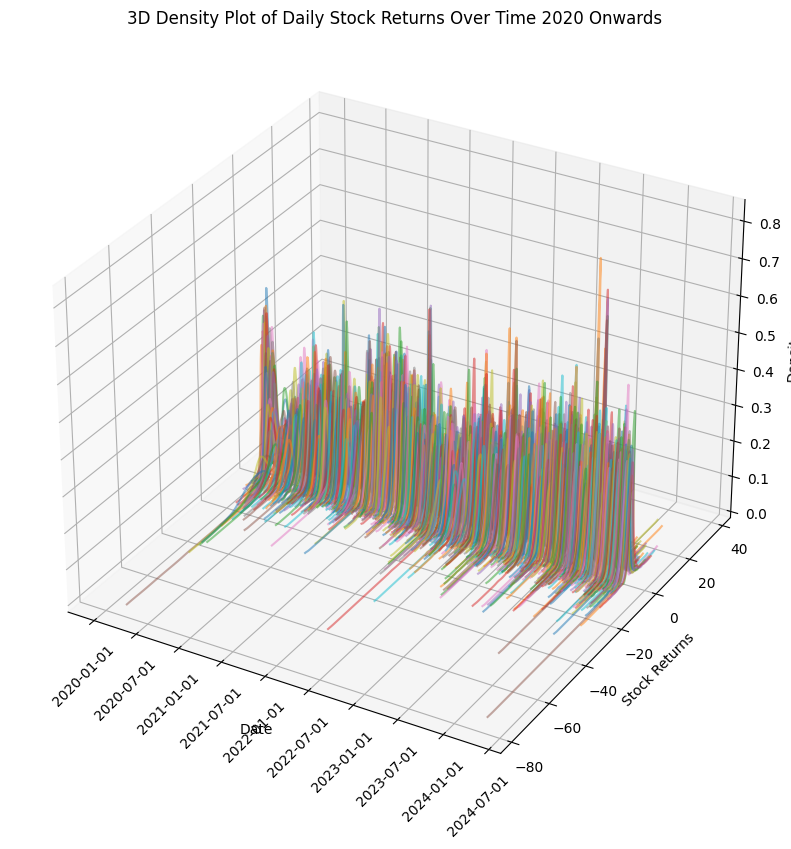

In [ ]:
# Create a new figure for the 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Iterate over each day, calculate KDE, and plot
for i, (date, daily_returns) in enumerate(log_returns_2020_onwards.iterrows()):
    data = daily_returns.dropna()
    if len(data) > 1:  # Ensure there's enough data to compute KDE
        try:
            kde = gaussian_kde(data)
            # Evaluate KDE on a range of data points
            kde_space = np.linspace(min(data), max(data), 100)
            density = kde(kde_space)
            ax.plot(np.full_like(kde_space, mdates.date2num(date.to_pydatetime())), kde_space, density, alpha=0.5)
        except np.linalg.LinAlgError:
            print(f"Failed to compute KDE for {date} due to singular matrix issues.")
            continue  # Skip this iteration if KDE computation fails

# Formatting the x-axis to show dates properly
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Labeling the axes
ax.set_xlabel('Date')
ax.set_ylabel('Stock Returns')
ax.set_zlabel('Density')

# Rotate the x-axis labels for better visibility
for label in ax.get_xticklabels():
    label.set_rotation(45)


plt.title('3D Density Plot of Daily Stock Returns Over Time 2020 Onwards')
plt.show()

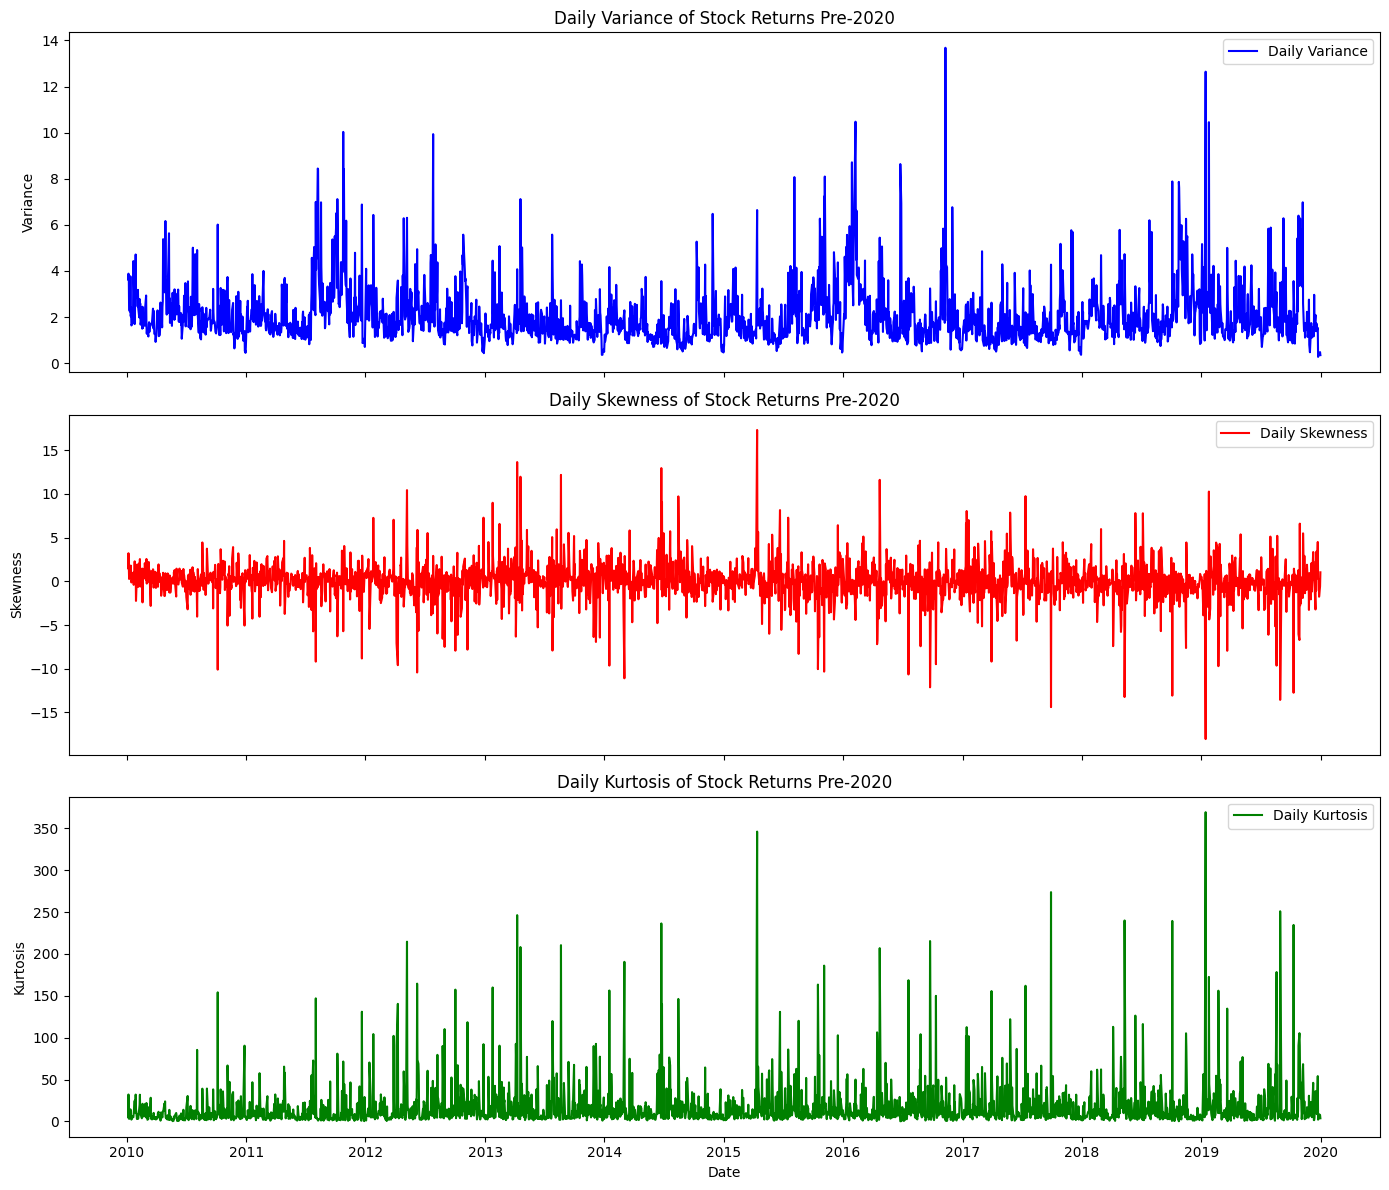

In [ ]:
# Calculate daily statistics
daily_stats_pre_2020 = log_returns_pre_2020.apply(lambda x: calculate_statistics(x.dropna()), axis=1)

# Convert the list of tuples into a DataFrame
daily_stats_pre_2020_df = pd.DataFrame(list(daily_stats_pre_2020), index=log_returns_pre_2020.index, columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'])

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plotting each statistic with labeled axes
axes[0].plot(daily_stats_pre_2020_df.index, daily_stats_pre_2020_df['Variance'], label='Daily Variance', color='blue')
axes[0].set_title('Daily Variance of Stock Returns Pre-2020')
axes[0].set_ylabel('Variance')

axes[1].plot(daily_stats_pre_2020_df.index, daily_stats_pre_2020_df['Skewness'], label='Daily Skewness', color='red')
axes[1].set_title('Daily Skewness of Stock Returns Pre-2020')
axes[1].set_ylabel('Skewness')

axes[2].plot(daily_stats_pre_2020_df.index, daily_stats_pre_2020_df['Kurtosis'], label='Daily Kurtosis', color='green')
axes[2].set_title('Daily Kurtosis of Stock Returns Pre-2020')
axes[2].set_ylabel('Kurtosis')
axes[2].set_xlabel('Date')


for ax in axes:
    ax.legend()


plt.tight_layout()
plt.show()


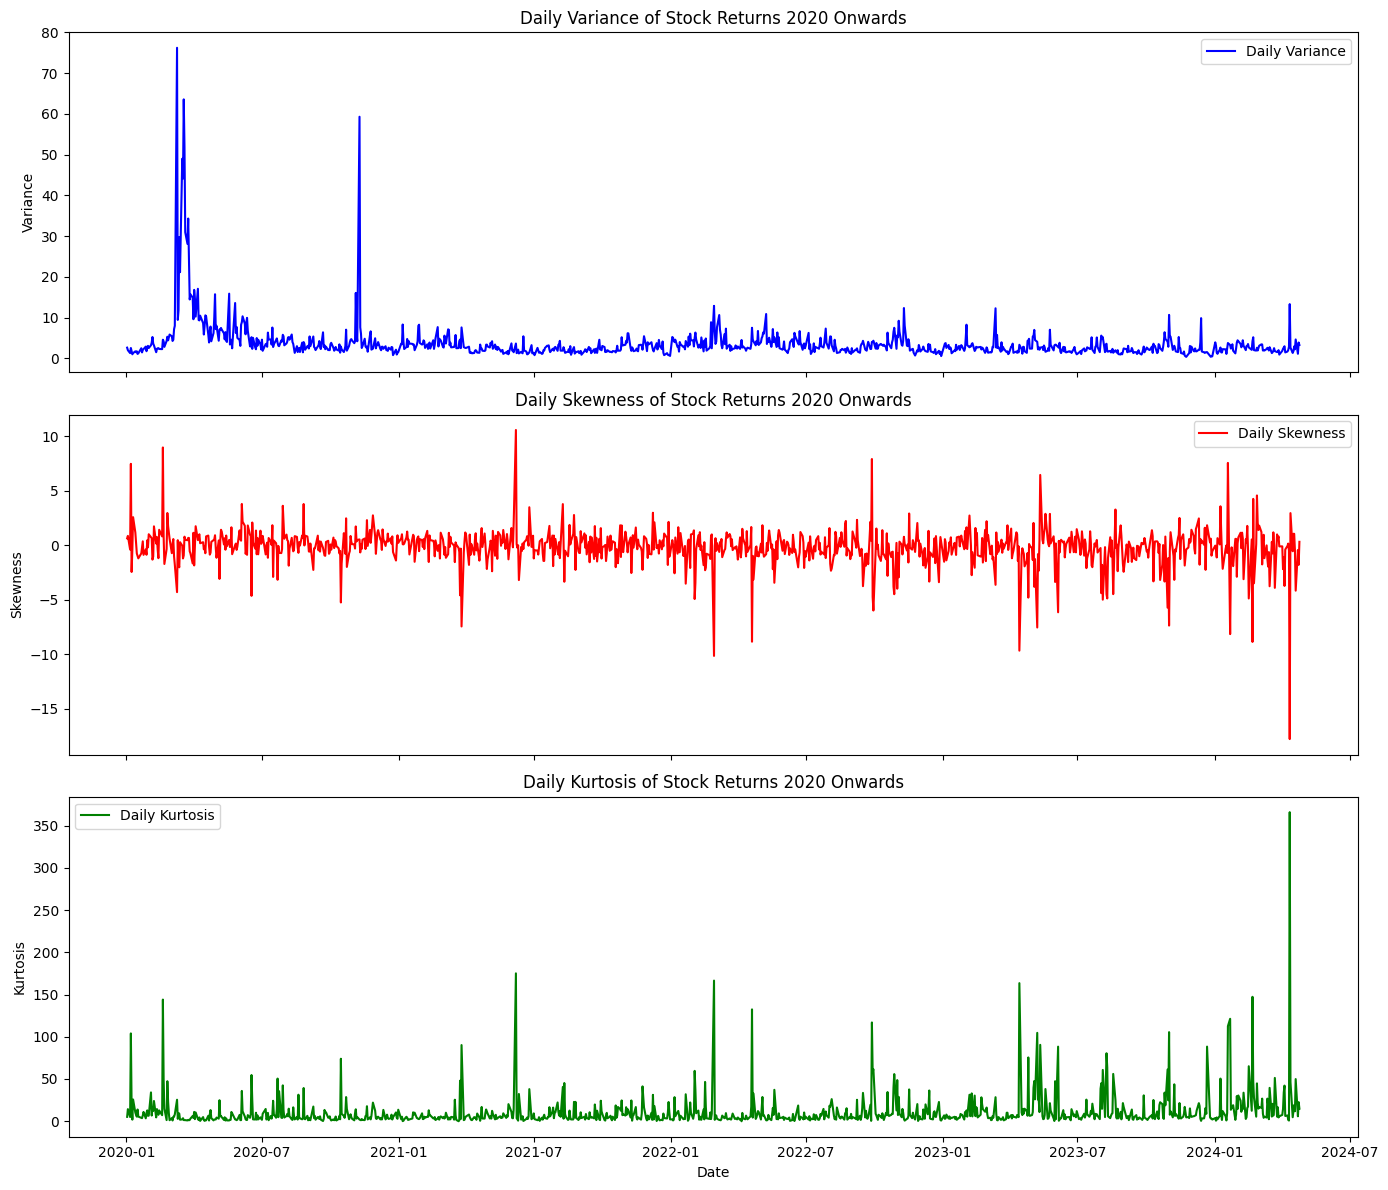

In [ ]:
# Calculate daily statistics
daily_stats_2020_onward = log_returns_2020_onwards.apply(lambda x: calculate_statistics(x.dropna()), axis=1)

# Convert the list of tuples into a DataFrame
daily_stats_2020_onward_df = pd.DataFrame(list(daily_stats_2020_onward), index=log_returns_2020_onwards.index, columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'])

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plotting each statistic with labeled axes
axes[0].plot(daily_stats_2020_onward_df.index, daily_stats_2020_onward_df['Variance'], label='Daily Variance', color='blue')
axes[0].set_title('Daily Variance of Stock Returns 2020 Onwards')
axes[0].set_ylabel('Variance')

axes[1].plot(daily_stats_2020_onward_df.index, daily_stats_2020_onward_df['Skewness'], label='Daily Skewness', color='red')
axes[1].set_title('Daily Skewness of Stock Returns 2020 Onwards')
axes[1].set_ylabel('Skewness')

axes[2].plot(daily_stats_2020_onward_df.index, daily_stats_2020_onward_df['Kurtosis'], label='Daily Kurtosis', color='green')
axes[2].set_title('Daily Kurtosis of Stock Returns 2020 Onwards')
axes[2].set_ylabel('Kurtosis')
axes[2].set_xlabel('Date')


for ax in axes:
    ax.legend()


plt.tight_layout()
plt.show()

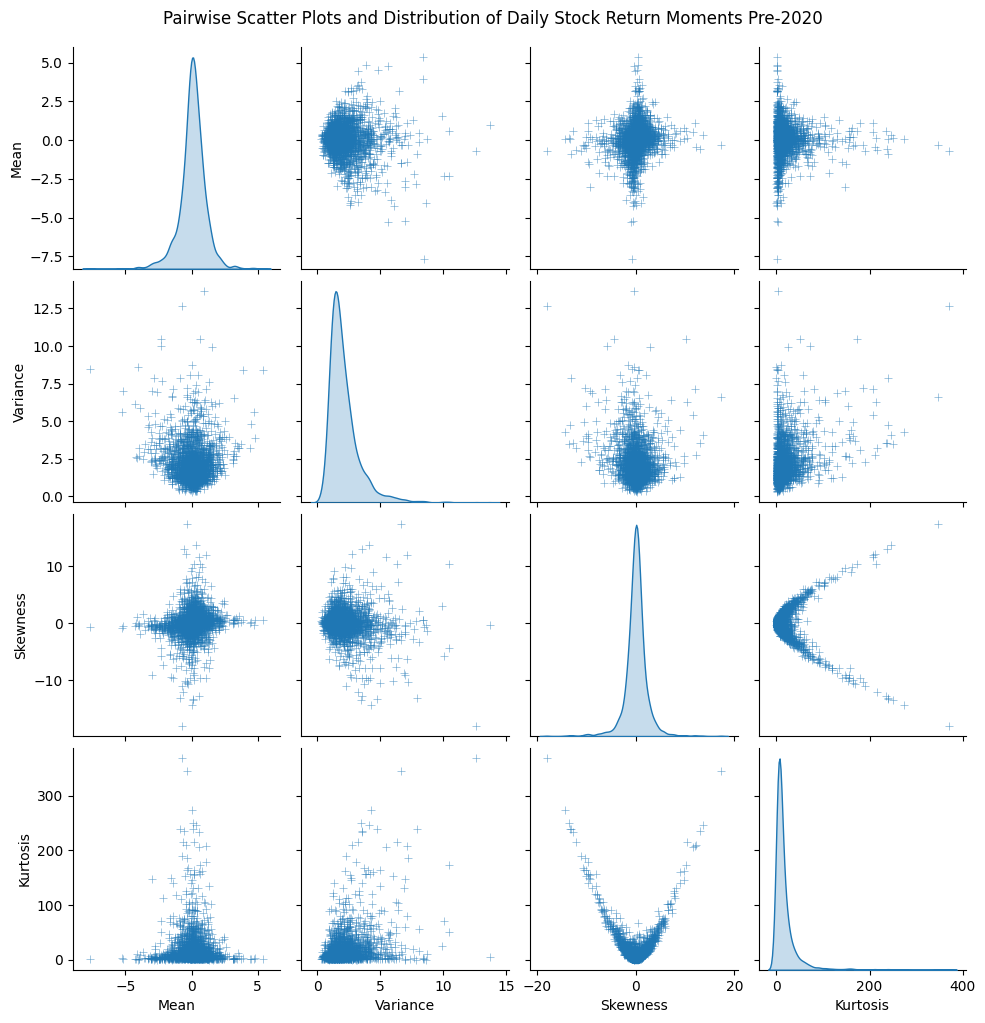

In [ ]:
# Create a pairplot of the daily statistics
sns.pairplot(daily_stats_pre_2020_df, diag_kind='kde', markers='+', plot_kws={'alpha': 0.6})
plt.suptitle('Pairwise Scatter Plots and Distribution of Daily Stock Return Moments Pre-2020', y=1.02)
plt.show()

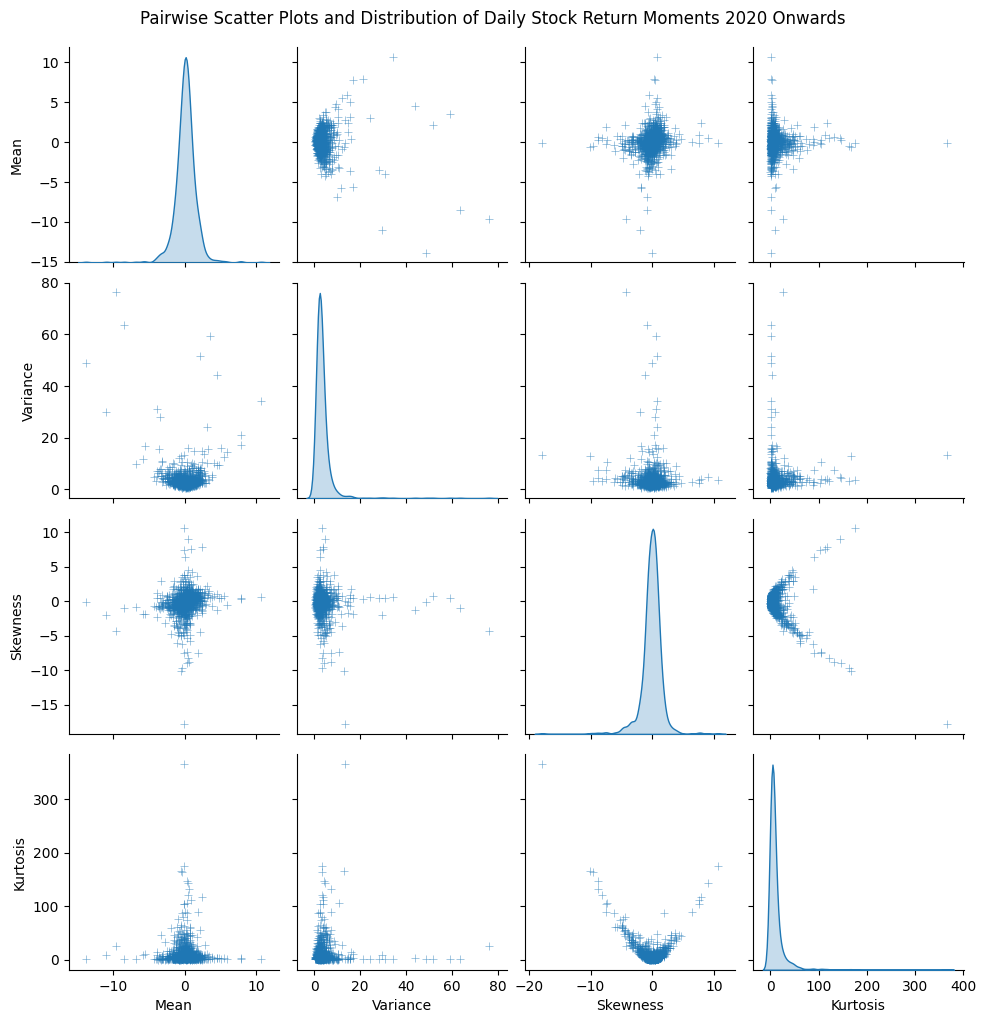

In [ ]:
# Create a pairplot of the daily statistics
sns.pairplot(daily_stats_2020_onward_df, diag_kind='kde', markers='+', plot_kws={'alpha': 0.6})
plt.suptitle('Pairwise Scatter Plots and Distribution of Daily Stock Return Moments 2020 Onwards', y=1.02)
plt.show()

It seems that most stock returns have more extreme values after 2020 and wider ranges of mean values, which made the trends are harder to grasp. The relationship between the moments was more abstract as well, partly because of fewer data.

## Question 6

In [ ]:
from scipy.stats import ks_2samp

sp500_returns_pre_2020 = log_returns_pre_2020['^GSPC'].dropna()
sp500_returns_2020_onwards = log_returns_2020_onwards['^GSPC'].dropna()

# Perform the KS test
ks_stat, p_value = ks_2samp(sp500_returns_pre_2020, sp500_returns_2020_onwards)

print("KS statistic:", ks_stat)
print("P-value:", p_value)


KS statistic: 0.08786726644739856
P-value: 1.5171748105302474e-05


In genereal, the distributions did not change too much. the p-value is greater than 0.05, you do not reject the null hypothesis, suggesting that there is no significant difference in the distributions between the two periods.

## Question 7

In [ ]:
# Function to compute annual returns for a specific year
def compute_year_returns(data, year):
    # Find the start and end dates for the specified year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    year_data = data.loc[start_date:end_date]

    # Calculate the year return
    year_start = year_data.iloc[0]
    year_end = year_data.iloc[-1]
    year_return = (year_end - year_start) / year_start * 100

    return year_return

# Generate annual returns
year_2022_returns = compute_year_returns(sp500_data, 2022)

# Sort the year returns to get the top ten and bottom ten stocks
year_2022_sorted = year_2022_returns.dropna().sort_values(ascending=False)
top_ten_stocks = year_2022_sorted.head(10)  # Top ten
bottom_ten_stocks = year_2022_sorted.tail(10)  # Bottom ten



In [ ]:
#create the dataframe to show the table for top and bottom ten stocks
top_bottom_stocks = pd.DataFrame({
    'Stock': top_ten_stocks.index.tolist() + bottom_ten_stocks.index.tolist(),
    'Year Return': top_ten_stocks.tolist() + bottom_ten_stocks.tolist(),
})


top_bottom_stocks

,Stock,Year Return
0,OXY,104.496497
1,HES,87.048501
2,MPC,81.876270
3,XOM,80.477847
4,SMCI,79.964929
5,SLB,71.044038
6,VLO,70.349847
7,FSLR,69.101366
8,APA,69.083620
9,COP,67.991200


In [ ]:
#define fetch esg score function by scraching webpages
def fetch_esg_score(ticker):
    url = f"https://finance.yahoo.com/quote/{ticker}/sustainability"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        # Assuming ESG score is stored within a <div> with a specific class name
        # This class name is a placeholder and needs to be replaced with the actual class name from the webpage
        esg_score = soup.find('h4', class_='border svelte-y3c2sq')
        if esg_score:
            return float(esg_score.text.strip())
    return None  # Return None if the page doesn't load properly or score isn't found


In [ ]:
# Example tickers known to have ESG scores
test_tickers = ['AAPL', 'GOOGL', 'MSFT']

# Fetch ESG scores using your function
for ticker in test_tickers:
    esg_score = fetch_esg_score(ticker)
    print(f"Ticker: {ticker}, ESG Score: {esg_score}")

Ticker: AAPL, ESG Score: 17.2
Ticker: GOOGL, ESG Score: 24.2
Ticker: MSFT, ESG Score: 15.1


In [ ]:
#get top and bottom ten tickers
top_ten_tickers = top_ten_stocks.index.tolist()
bottom_ten_tickers = bottom_ten_stocks.index.tolist()

#get the scores
top_ten_esg_scores = {ticker: fetch_esg_score(ticker) for ticker in top_ten_tickers}
bottom_ten_esg_scores = {ticker: fetch_esg_score(ticker) for ticker in bottom_ten_tickers}

print(top_ten_esg_scores)
print(bottom_ten_esg_scores)

No ESG score found for SMCI
No ESG score found for FSLR
No ESG score found for WBD
No ESG score found for CTLT
No ESG score found for ALGN
No ESG score found for MTCH
No ESG score found for GNRC
{'OXY': 41.7, 'HES': 33.1, 'MPC': 30.5, 'XOM': 41.6, 'SMCI': None, 'SLB': 20.3, 'VLO': 32.6, 'FSLR': None, 'APA': 38.8, 'COP': 33.9}
{'SWK': 25.3, 'CCL': 24.5, 'WBD': None, 'PYPL': 17.8, 'CTLT': None, 'META': 34.1, 'ALGN': None, 'MTCH': None, 'TSLA': 25.2, 'GNRC': None}


In [ ]:
# Convert scores to float and prepare lists, filtering out None values
top_scores = [float(score) for score in top_ten_esg_scores.values() if score is not None]
bottom_scores = [float(score) for score in bottom_ten_esg_scores.values() if score is not None]

# Perform ANOVA test
anova_result = stats.f_oneway(top_scores, bottom_scores)
print('ANOVA test result:', anova_result)

ANOVA test result: F_onewayResult(statistic=5.348125044667129, pvalue=0.04110999376728529)


A p-value of less than 0.05 is considered statistically significant. At the 5% significance level, we may conclude that the means of the ESG scores for top and bottom stock performers are different.

In [ ]:
#get sp500 tickers
def get_sp500_tickers():
        table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        sp500 = table[0]
        tickers = sp500['Symbol'].tolist()
        tickers = [ticker.replace('.', '-') for ticker in tickers]  # Yahoo Finance uses hyphens instead of dots
        return tickers

sp500_tickers = get_sp500_tickers()
print(sp500_tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [ ]:
def get_stock_info(tickers):
    # Dictionary to hold the data
    data = {
        'Ticker': [],
        'Industry': [],
        'Sector': []
    }

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        info = stock.info  # This retrieves a dictionary of stock information

        # Extract industry and sector information
        data['Ticker'].append(ticker)
        data['Industry'].append(info.get('industry', 'N/A'))  # Get industry, return 'N/A' if not found
        data['Sector'].append(info.get('sector', 'N/A'))  # Get sector, return 'N/A' if not found

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)
    return df

# Example usage with a list of tickers

industry_info = get_stock_info(sp500_tickers)
print(industry_info)


    Ticker                                  Industry             Sector
0      MMM                             Conglomerates        Industrials
1      AOS            Specialty Industrial Machinery        Industrials
2      ABT                           Medical Devices         Healthcare
3     ABBV              Drug Manufacturers - General         Healthcare
4      ACN           Information Technology Services         Technology
..     ...                                       ...                ...
498    XYL            Specialty Industrial Machinery        Industrials
499    YUM                               Restaurants  Consumer Cyclical
500   ZBRA                   Communication Equipment         Technology
501    ZBH                           Medical Devices         Healthcare
502    ZTS  Drug Manufacturers - Specialty & Generic         Healthcare

[503 rows x 3 columns]


In [ ]:
#fetch esg_score for each ticker
industry_info['ESG Score'] = industry_info['Ticker'].apply(lambda x: fetch_esg_score(x))
industry_groups = industry_info.groupby('Industry')

In [ ]:
industry_info['ESG Score'] = industry_info['Ticker'].apply(lambda x: fetch_esg_score(x))
industry_groups = industry_info.groupby('Industry')

for name, group in industry_groups:
    # Filter out rows where 'ESG Score' is None
    filtered_group = group.dropna(subset=['ESG Score'])

    if not filtered_group.empty:  # Only plot if there's data to plot
        plt.figure()
        plt.scatter(filtered_group['Ticker'], filtered_group['ESG Score'], label=f"{name} Industry")
        plt.xlabel('Ticker')
        plt.ylabel('ESG Score')
        plt.title(f'ESG Scores in {name} Industry')
        plt.legend()
        plt.show()

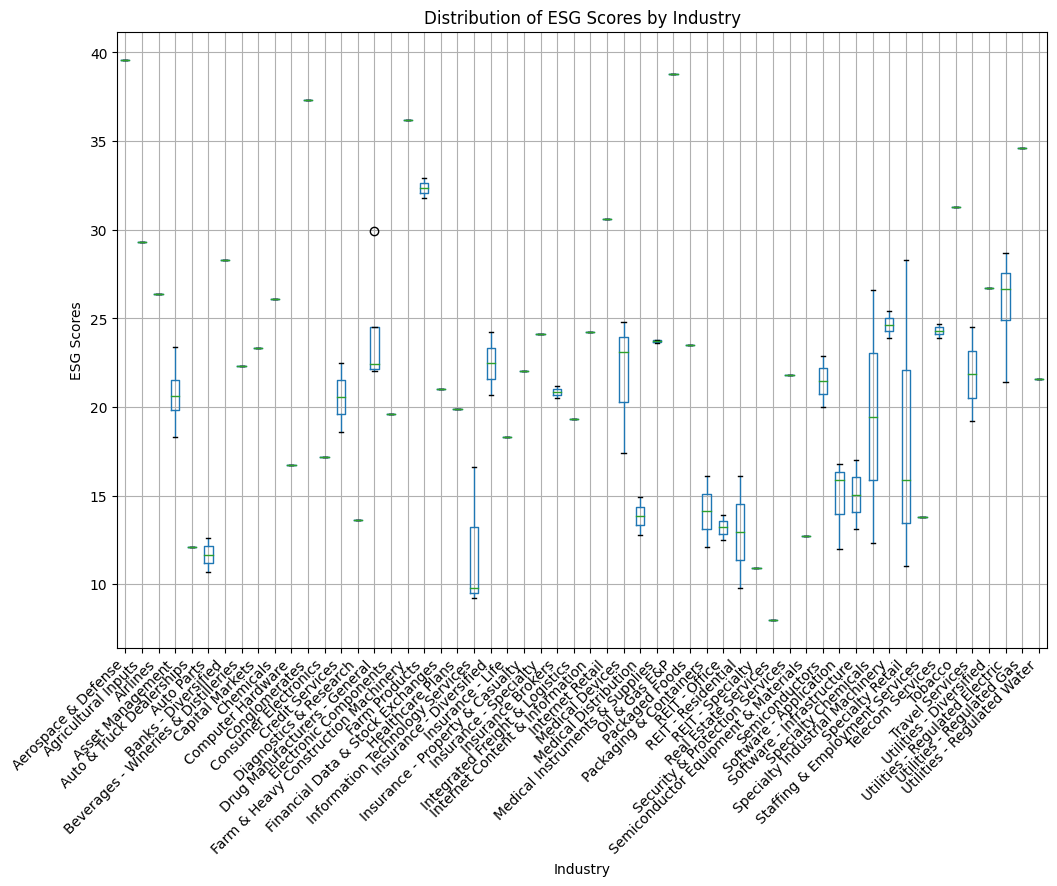

In [ ]:
# Group data by Industry
industry_groups = industry_info.groupby('Industry')['ESG Score']

# Prepare a new DataFrame for plotting
data_to_plot = {name: group.values for name, group in industry_groups if not group.dropna().empty}

# Create a DataFrame from the dictionary
plot_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in data_to_plot.items()]))

# Create box plot
plt.figure(figsize=(12, 8))
boxplot = plot_df.boxplot()
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of ESG Scores by Industry')
plt.xlabel('Industry')
plt.ylabel('ESG Scores')
plt.show()

In [ ]:
#create sector groups to show
sector_groups = industry_info.groupby('Sector')

for name, group in sector_groups:
    # Filter out rows where 'ESG Score' is None
    filtered_group1 = group.dropna(subset=['ESG Score'])

    if not filtered_group1.empty:  # Only plot if there's data to plot
        plt.figure()
        plt.scatter(filtered_group1['Ticker'], filtered_group1['ESG Score'], label=f"{name} Sector")
        plt.xlabel('Ticker')
        plt.ylabel('ESG Score')
        plt.title(f'ESG Scores in {name} Sector')
        plt.legend()
        plt.show()

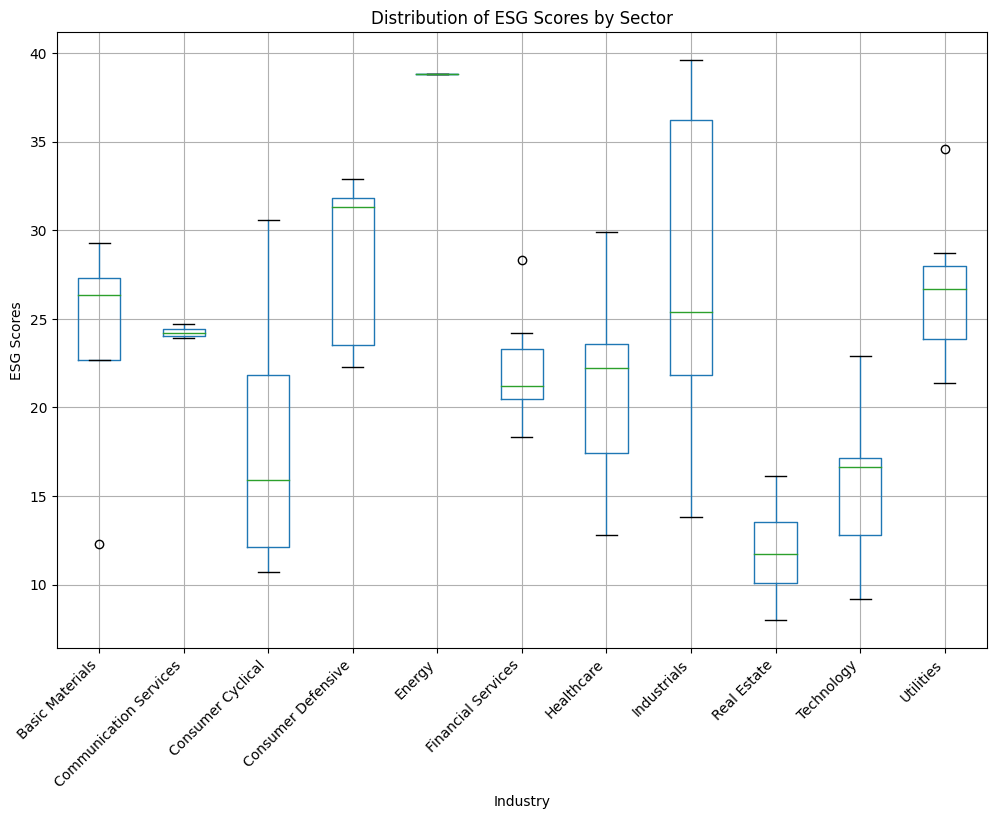

In [ ]:
# Group data by Sector
sector_groups = industry_info.groupby('Sector')['ESG Score']

# Prepare a new DataFrame for plotting
data_to_plot = {name: group.values for name, group in sector_groups if not group.dropna().empty}

# Create a DataFrame from the dictionary
plot_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in data_to_plot.items()]))

# Create box plot
plt.figure(figsize=(12, 8))
boxplot = plot_df.boxplot()
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of ESG Scores by Sector')
plt.xlabel('Industry')
plt.ylabel('ESG Scores')
plt.show()

While Real estate and technology have lower ESG scores in general, consumer cyclical and industrials have larger ranges.